# ARIMAX Forecasting Workflow: AAPL Stock Prices

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Wearnings
import warnings
warnings.filterwarnings("ignore")

# Define BASE_DIR and adjust sys.path before importing
BASE_DIR = Path(os.getcwd()).parent  # Points to stat_656_autotrader/ from Notebooks/
sys.path.append(str(BASE_DIR))
print(f"Project root added to sys.path: {BASE_DIR}")

# Importing custom modules
from src.utils.db_utils import fetch_price_range
from src.statistics import log_difference, smooth_lowess, check_stationarity
from src.models.forecasting.arimax import select_best_arimax, forecast_arimax
from src.statistics.changepoints import detect_level_shifts


Project root added to sys.path: d:\dev\stat_656_autotrader


# Step 2: Fetch Historical Data

In [2]:
ticker = 'AAPL'
days_back = 250
df = fetch_price_range(ticker, days_back)
df = df.dropna().reset_index(drop=True)
display(df.head())

Connecting to database: D:\dev\stat_656_autotrader\databases\assets.db
Querying AAPL prices for last 250 trading days from 2024-04-17 to 2025-04-15
Fetched 250 price records for AAPL


,date,open,high,low,close
0,2024-04-17,169.53,170.63,168.00,168.01
1,2024-04-18,168.06,168.62,166.57,167.03
2,2024-04-19,165.99,166.38,164.08,164.96
3,2024-04-22,165.53,167.25,164.78,165.91
4,2024-04-23,165.35,167.05,165.03,166.81


# Step 3: Smooth Prices using LOWESS

In [3]:
smoothing_window = 5
for col in ['open', 'high', 'low', 'close']:
    df[f'{col}_smooth'] = smooth_lowess(df[col], window_length=smoothing_window)

In [11]:
print(len(df['date']))
print(len(df['close']))
print(len(df['close_smooth']))

250
250
250


# Step 4: Visualize Original vs. Smoothed Prices

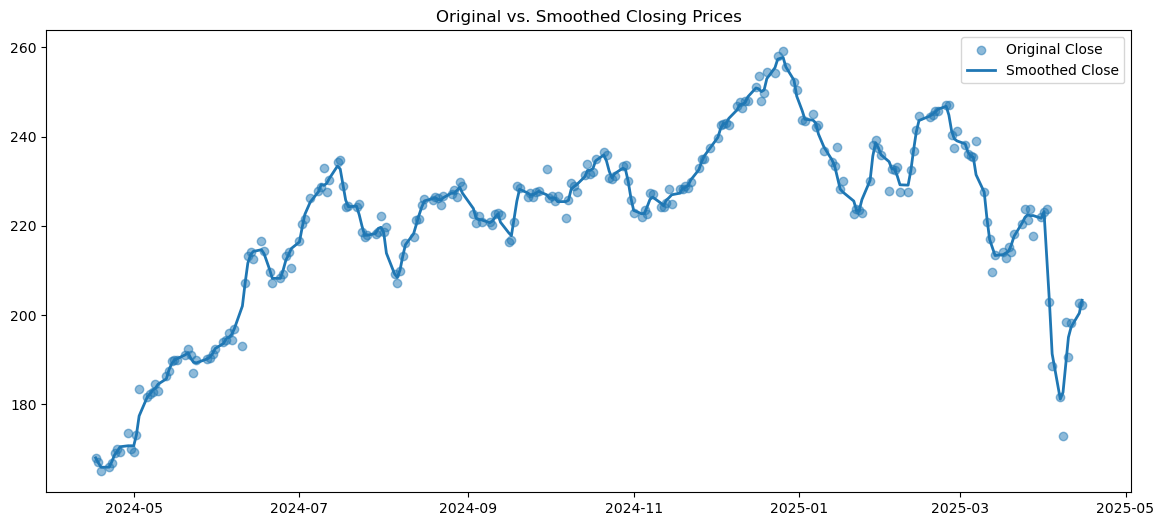

In [12]:
plt.figure(figsize=(14, 6))
plt.scatter(df['date'],df['close'], label='Original Close', alpha=0.5)
plt.plot(df['date'],df['close_smooth'], label='Smoothed Close', linewidth=2)
plt.title('Original vs. Smoothed Closing Prices')
plt.legend()
plt.show()

# Step 5: Log-differencing and Stationarity Check

In [16]:
def is_series_stationary(series, signif=0.05):
    """
    Check if a time series is stationary based on both ADF and KPSS tests.

    Parameters:
    -----------
    series : pd.Series
        The series to test for stationarity.
    signif : float, optional
        Significance level for both tests (default: 0.05).

    Returns:
    --------
    bool
        True if series is stationary, False otherwise.
    """
    stationarity_results = check_stationarity(series, signif)
    
    adf_stationary = stationarity_results['ADF']['is_stationary']
    kpss_stationary = stationarity_results['KPSS']['is_stationary']
    
    return adf_stationary and kpss_stationary

df['close_logdiff'] = log_difference(df['close_smooth'])
is_stationary = is_series_stationary(df['close_logdiff'].dropna())
print(is_stationary)


True


# Step 6: Check Recent Level Shifts

In [14]:
shifts = detect_level_shifts(df['close_smooth'])
print("Detected level shifts at indices:", shifts)

Detected level shifts at indices: [35, 80, 110, 155, 185, 220]


In [15]:
# Ensure enough observations after the last level shift
min_observations_after_shift = 50
if shifts and (len(df) - shifts[-1]) < min_observations_after_shift:
    raise ValueError(f"Not enough observations after last shift at {shifts[-1]}")

ValueError: Not enough observations after last shift at 220